In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.dpi'] = 70 #display 70 dpi in Jupyter Notebook, may consider100 dpi 
plt.rcParams['savefig.dpi'] = 300 #define 300 dpi for saving figures

import seaborn as sns
## here are some settings 
sns.set_style('whitegrid')
sns.set(rc={"figure.dpi":70, 'savefig.dpi':300}) #defining dpi setting
sns.set_context('notebook')
sns.set_style("ticks")
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')
from tqdm import tqdm
import numpy as np
import wfdb

C:\Users\Luke\AppData\Local\Temp\ipykernel_8344\2932441138.py:13: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('retina')


In [2]:
# Tells matplotlib to display images inline instead of a new window
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from time import time
import timeit #imports timeit module
start_time = timeit.default_timer() #defines start time so computational time can be calculated
print("Hello World")
elapsed = timeit.default_timer() - start_time #gives total computation time
print("---Run time is %s seconds ---" % elapsed) #prints computation time
print()

Hello World
---Run time is 0.00013979999999946813 seconds ---



In [3]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.preprocessing import PolynomialFeatures

import sklearn.linear_model as skl_lm
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn import neighbors
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis 
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis


from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import LeaveOneOut

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score

In [4]:
#data = load_breast_cancer(as_frame = True); 
#df = data.frame; 
#print(df.shape)
# In this block use the code we looked at on 6/30 as a reference to save our rr-intervals as a .
rlist = []
records = 'mit-bih-raw\RECORDS' # Replace the _______ with the name of the records file in your MIT-BIH data folder
with open(records) as rfile: #Then we open the file 
                             #The 'with' command only opens the file while we are in it. Automatically closes the file when we're not
    for record in rfile:  # Then we iterate through the lines in the file
        record = record[0:len(record)-1] # Remove any erronious new line characters at the end ('\n')
        rlist.append(record) # Then build an array with it
        

###### Step 1: Initialize all Arrays
             # Below, replace all of the ___ with the command that declares an array/list
             # hint: https://stackoverflow.com/questions/1514553/how-to-declare-an-array-in-python
samples = [] # will house the samples of all subjects
good_list = [] # will list the names of the subjects we successfully extracted
bad_list = [] # will house the names of the subjects we failed to extract
qrs = [] # will house the indices of R-Peaks for all subjects
atr_label = [] # will house the labels for each rhythm annotation for all subjects
atr_locs = [] # will house the locations corresponding to the rhythm annotation labels


###### Step 2: Extract Information
for x in tqdm(rlist): #this will iterate through te records that we found above
  
    try: # A try statement will run the except statement if for some reason the try commands fail
         # In this case I use the try statement because one of the subjects has no signal data causing failure
         # I then use bad_list and good_list so that all of the indices in rlist match with the arrays we initialized in Step 1, above
        ######################################################
            # Below find the wfdb function that will return the information that is described below 
        # Then replace _____ with the correct function call
        samp = wfdb.rdsamp('mit-bih-raw/'+x) # wfdb._____(file_location) will read the signal & header data and return a 2 value array
            # samp[0] - the signal data is the raw reading from the ecg. Each value is a sample taken.
            # samp[1] - the header data includes things about the signal data such as:
              # samples per section, denoted 'fs'
              # number of signals, denoted 'n_sig'
            
        ######################################################
        samples.append(samp) #add it to our array for all subject
            #What is our file extension that has the annotation we want? Find it here and replace _____ with it 
            #hint: READ THE VARIABLE NAMES!!!!
        qrs_tmp = wfdb.rdann('mit-bih-raw/'+x, extension='qrs') #extract the QRS Info
        qrs_locs = np.array(qrs_tmp.sample, dtype='int') #Get just the loccation of R-Peaks from the QRS Info
        qrs.append(qrs_locs) # Add to our array for all subjects
        
            #Do the same thing here
        atr = wfdb.rdann('mit-bih-raw/'+x,extension='atr') #extract the atr info which stores the rhythm type(s) over the whole signal
        atr_label.append(atr.aux_note) # aux_note stores the type of rhythm - main two are '(N' for normal and '(AFIB' for AFIB
        atr_locs.append(np.append(atr.sample, len(samp[0]))) #I add the length of the whole sample to the end for better visualization later
        
        good_list.append(x) # when all extraction is successful append the record name to good_list
    except Exception as exep:
        print(exep) # Alert the user of an exception
        bad_list.append(x) # add to the bad list

        

  0%|          | 0/25 [00:00<?, ?it/s]

sampto must be greater than sampfrom
sampto must be greater than sampfrom


100%|██████████| 25/25 [00:46<00:00,  1.86s/it]


In [5]:
features_df_list = []
for subject in good_list:
    data = pd.read_csv(f'subject-features-dataframes/subject{subject}.csv')
    data = data.assign(Subject = subject)
    #print(data)
    features_df_list.append(data)
features_maindf = pd.concat(features_df_list, ignore_index = True)

In [6]:
x_values = ['StoS', 'StoR', 'StoL', 'RtoS', 'RtoR', 'RtoL', 'LtoS',
       'LtoR', 'LtoL', 'STD', 'CoefVar', 'Range', 'Volatility', 'ShEn',
       'AppEn', 'SampEn']
y_values = ['Rhythm']
#for df in features_df_list:
df = features_maindf
crossvalidation = KFold(n_splits=23)
df = features_maindf
acc_score = [];
Truth = [];
Output = [];
for idx, subject in enumerate(good_list):
    
    train_index = ~df['Subject'].str.contains(subject)
    test_index = df['Subject'].str.contains(subject)
    X_train , X_test = df.loc[train_index,x_values], df.loc[test_index,x_values]
    y_train , y_test = df.loc[train_index,y_values].values.ravel(), df.loc[test_index,y_values]

    lda = LinearDiscriminantAnalysis()
    model = lda.fit(X_train, y_train)

    pred_values = model.predict(X_test)
    pred_prob = model.predict_proba(X_test)[:, 1]
     
    acc = accuracy_score(y_test, pred_values)
    acc_score.append(acc)
    #confusion_matrix_df.loc[idx] = confusion_matrix(Truth, Output).ravel()
    Truth.extend(y_test.values.reshape(y_test.shape[0])); ## it is a list
    Output.extend(pred_values); ## it is a list 
    
#X = df2.loc[:, ["student", "balance", "income"]] #student; balance; income
#X = df2.loc[:, ["balance", "income"]] #student; balance; income
#y = df2.loc[:, "default"] #default
elapsed = timeit.default_timer() - start_time #gives total computation time
print("---Run time is %s seconds ---" % elapsed) #prints computation time
print()

print('Accuracy of each fold: \n {}'.format(acc_score))
print()
print('Avg accuracy : \n{}'.format(np.mean(acc_score))); 
print()
print('Std of accuracy : \n{}'.format(np.std(acc_score)))

In [7]:
print(acc_score)
print(confusion_matrix(Truth, Output))
print(classification_report(Truth, Output))

[0.9107551487414187, 0.9553752535496958, 0.9955919395465995, 0.9412470023980816, 0.9973876698014629, 0.9342799188640973, 0.8668846333489024, 0.9972770592239619, 0.9487951807228916, 0.9652701212789415, 0.9827586206896551, 0.9899497487437185, 0.7977324263038549, 0.9426751592356688, 0.4704412989175687, 0.9782897651750111, 0.9910897875257025, 0.9826889786497404, 0.7404902789518174, 0.9631665750412315, 0.9923011120615911, 0.9956057752667922, 0.9898520084566597]
[[23025  1718]
 [ 1956 18269]]
              precision    recall  f1-score   support

           0       0.92      0.93      0.93     24743
           1       0.91      0.90      0.91     20225

    accuracy                           0.92     44968
   macro avg       0.92      0.92      0.92     44968
weighted avg       0.92      0.92      0.92     44968



### Linear Discriminant Analysis

In [8]:
# crossvalidation = KFold(n_splits=5, random_state=2, shuffle=True)

# lda = LinearDiscriminantAnalysis()
# model = lda.fit(X, y)

# scores = cross_val_score(model, X, y, cv=crossvalidation)
# print('Accuracy of each fold: \n {}'.format(scores))
# print()
# print("Avg accuracy: {}".format(scores.mean()))

### Quadratic Discriminant Analysis

<AxesSubplot:>

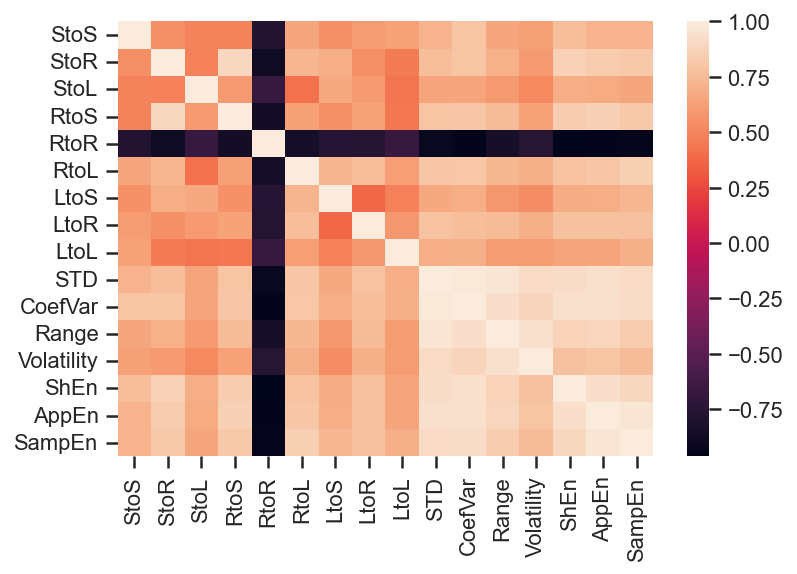

In [9]:
sns.heatmap(features_df_list[0][x_values].corr())

In [10]:
x_values = ['StoS', 'StoL', 'LtoS', 'LtoL', 'SampEn']
y_values = ['Rhythm']
#for df in features_df_list:
df = features_maindf
df = features_maindf
acc_score = [];
Truth = [];
Output = [];
crossvalidation = KFold(n_splits=23)
for idx, subject in enumerate(good_list):
    
    train_index = ~df['Subject'].str.contains(subject)
    test_index = df['Subject'].str.contains(subject)
    X_train , X_test = df.loc[train_index,x_values], df.loc[test_index,x_values]
    y_train , y_test = df.loc[train_index,y_values], df.loc[test_index,y_values]


    qda = QuadraticDiscriminantAnalysis()
    model = qda.fit(X_train, y_train.values.ravel())

    pred_values = model.predict(X_test)
    pred_prob = model.predict_proba(X_test)[:, 1]
     
    acc = accuracy_score(y_test, pred_values)
    acc_score.append(acc)
    #confusion_matrix_df.loc[idx] = confusion_matrix(Truth, Output).ravel()
    Truth.extend(y_test.values.reshape(y_test.shape[0])); ## it is a list
    Output.extend(pred_values); ## it is a list
elapsed = timeit.default_timer() - start_time #gives total computation time
print("---Run time is %s seconds ---" % elapsed) #prints computation time
print()

print('Accuracy of each fold: \n {}'.format(acc_score))
print()
print('Avg accuracy : \n{}'.format(np.mean(acc_score))); 
print()
print('Std of accuracy : \n{}'.format(np.std(acc_score)))

In [11]:
print(acc_score)
print(confusion_matrix(Truth, Output))
print(classification_report(Truth, Output))

[0.9061784897025171, 0.9363083164300203, 0.9937027707808564, 0.7805755395683454, 0.9926854754440961, 0.9448275862068966, 0.7907519850537132, 0.9639210347174949, 0.9236947791164659, 0.9305402425578831, 0.9804900181488203, 0.968413496051687, 0.8530612244897959, 0.9942675159235669, 0.3717735220649459, 0.9268941072219761, 0.9869773817683345, 0.9924985574148875, 0.7616229923922232, 0.920285871357889, 0.9828913601368692, 0.9648462021343377, 0.9784355179704017]
[[22462  2281]
 [ 2327 17898]]
              precision    recall  f1-score   support

           0       0.91      0.91      0.91     24743
           1       0.89      0.88      0.89     20225

    accuracy                           0.90     44968
   macro avg       0.90      0.90      0.90     44968
weighted avg       0.90      0.90      0.90     44968

